##  Imports

In [1]:
import sys
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

!{sys.executable} -m pip install chardet
import chardet

- [Fase 2](#Fase-2)
- [Fase 3](#Fase-3)
- [Fase 4](#Fase-4)

<a id="Funções"></a>

### Funções Auxiliares

In [2]:
def find_outliers_tucker(series, threshold=1.5):
    """
    Retorna os índices dos valores obtidos como outliers após calculados os limites superiores
    e inferiores da Series em questão, utilizando o algoritmo de Tucker.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1

    lower_limit = q1 - threshold * iqr
    upper_limit = q3 + threshold * iqr

    filtered_series = series[(series < lower_limit) | (series > upper_limit)]
    
    return filtered_series.index

def imputa_rua(bairro, df):
    return df[bairro]

def imputa_bairro(rua, df):
    rua_formatted = rua.split(',')[0]
    imoveis = df.loc[df['Rua'] == rua_formatted]

    if imoveis.shape[0] == 0:
        bairro = None
    else:
        bairro = imoveis['Bairro'].unique()[0]

    return bairro

def jupyter_settings():
    %matplotlib inline
    warnings.filterwarnings('ignore')

    plt.rcParams['figure.figsize'] = (24, 12)
    plt.rcParams['font.size'] = 24
    pd.set_option('display.float_format', '{:.2f}'.format)
    pd.set_option('display.max_columns', 100)

    sns.set()

jupyter_settings()

### Carregando os Dados

Carregando **dataset de imóveis** à venda na cidade de São Paulo

In [3]:
df_imoveis = pd.read_csv('./dados/dados_imoveis.csv')
df_imoveis.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000


<a id="Fase-2"></a>

# FASE 2
___

## Descrição dos Dados

In [4]:
df1_imoveis = df_imoveis.copy()

In [5]:
print('Número de linhas: ', df1_imoveis.shape[0])
print('Número de colunas: ', df1_imoveis.shape[1])

Número de linhas:  10008
Número de colunas:  8


In [6]:
df1_imoveis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rua        6574 non-null   object
 1   Bairro     9996 non-null   object
 2   Cidade     10008 non-null  object
 3   Metragem   10008 non-null  int64 
 4   Quartos    10008 non-null  int64 
 5   Banheiros  10008 non-null  int64 
 6   Vagas      10008 non-null  int64 
 7   Valor      10008 non-null  object
dtypes: int64(4), object(4)
memory usage: 625.6+ KB


### Tipos dos Dados

In [7]:
df1_imoveis.dtypes

Rua          object
Bairro       object
Cidade       object
Metragem      int64
Quartos       int64
Banheiros     int64
Vagas         int64
Valor        object
dtype: object

O tipo da coluna `Valor` está errado, devendo ser transformada para numérica. Escolhemos transformá-la para int64, o que será feito mais a frente na *seção 1.3*.

### Valores Nulos

In [8]:
df1_imoveis.isna().sum()

Rua          3434
Bairro         12
Cidade          0
Metragem        0
Quartos         0
Banheiros       0
Vagas           0
Valor           0
dtype: int64

As variáveis `Rua` e `Bairro` possuem valores nulos que precisam ser tratados posteriormente.

### Buscando Variáveis com Tipos de Dados Incorretos

**Variável `Valor`**

Analisando os valores desta coluna descobrimos que ela não somente mostra o valor absoluto das casas, mas para algumas linhas ela mostra o valor do aluguel, podendo este ser diário, mensal ou anual.

Aluguel Diário

In [9]:
df1_imoveis[df1_imoveis['Valor'].str.contains('Dia')]

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
6639,NaN,Jardim Guedala,São Paulo,572,4,6,7,R$ 15.000\r\n /Dia
7421,NaN,Jardim Guedala,São Paulo,577,4,6,7,R$ 15.000\r\n /Dia


Aluguel Mensal

In [10]:
df_imoveis_alugar = df1_imoveis[df1_imoveis['Valor'].str.contains('Mês')]
df_imoveis_alugar.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
151,Rua Fonseca da Costa,Bosque da Saúde,São Paulo,650,4,6,12,R$ 11.000\r\n /Mês
156,NaN,Jardim Paulistano,São Paulo,230,2,3,2,R$ 12.000\r\n /Mês
175,Rua Maestro Elias Lobo,Jardim Paulista,São Paulo,542,5,8,4,R$ 25.000\r\n /Mês
178,Rua Guararapes,Lapa,São Paulo,515,3,5,8,R$ 30.000\r\n /Mês
182,Rua Alvarenga,Butantã,São Paulo,400,4,3,4,R$ 10.000\r\n /Mês


Aluguel Anual

In [11]:
df1_imoveis[df1_imoveis['Valor'].str.contains('Ano')]

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
6029,NaN,Instituto de Previdência,São Paulo,120,3,1,2,R$ 2.600\r\n /Ano
6718,NaN,Instituto de Previdência,São Paulo,125,3,1,2,R$ 2.600\r\n /Ano


### Deletando esses imóveis:

In [12]:
# Deletando os imóveis de aluguel DIÁRIO
df1_imoveis.drop(df1_imoveis[df1_imoveis['Valor'].str.contains('Dia')].index, inplace=True)

# Deletando e salvando os imóveis de aluguel MENSAL
df1_imoveis.drop(df_imoveis_alugar.index, inplace=True)
df_imoveis_alugar.to_csv('./dados/dados_imoveis_alugar.csv')

# Deletando os imóveis de aluguel ANUAL
df1_imoveis.drop(df1_imoveis[df1_imoveis['Valor'].str.contains('Ano')].index, inplace=True)

**Resolvendo o tipo incorreto**

In [13]:
df1_imoveis['Valor'].sample(5)

8817    R$ 2.400.000
2302    R$ 1.780.000
193       R$ 620.000
3463      R$ 600.000
8202    R$ 1.200.000
Name: Valor, dtype: object

Corrigindo o tipo de dado da variável `Valor`

In [14]:
# Casting da variável Valor de Object para int64
df1_imoveis['Valor'] = df1_imoveis['Valor']\
    .str.replace('R\$|,', '', regex=True)\
        .str.replace('.', '').str.strip()

In [15]:
df1_imoveis['Valor'] = df1_imoveis['Valor'].astype(int)
df1_imoveis['Valor'].sample(5)

df1_relatorio = df1_imoveis.copy()

## Criando Novas Colunas 

In [16]:
df2_imoveis = df1_imoveis.copy()

#### Criando a coluna `Valor_m2`

Representa o valor médio do m2 para cada linha do dataframe.

In [17]:
df2_imoveis['Valor_m2'] = df2_imoveis['Valor'] / df2_imoveis['Metragem']
df2_imoveis['Valor_m2'].head()

0   7000.00
1   7459.68
2   3040.00
3   2209.68
4   5400.00
Name: Valor_m2, dtype: float64

## Estatísticas de Resumo

In [18]:
df3_imoveis = df2_imoveis.copy()

In [19]:
# dividindo o dataframe em variáveis numéricas e categóricas
num_attr, cat_attr = df3_imoveis.select_dtypes(include=[int, float]), df3_imoveis.select_dtypes(exclude=[int, float])

**Variáveis Numéricas**

In [20]:
num_attr.describe().rename({'count': 'Quantidade', 'max': 'Máximo', 'min': 'Mínimo', '50%': 'Mediana/Q2', 'mean': 'Média', '25%': 'Q1', '75%': 'Q3', 'std': 'Desvio Padrão'}).T

,Quantidade,Média,Desvio Padrão,Mínimo,Q1,Mediana/Q2,Q3,Máximo
Metragem,9156.00,434.42,7856.42,10.00,168.00,276.00,450.00,750000.00
Quartos,9156.00,3.45,1.05,1.00,3.00,3.00,4.00,16.00
Banheiros,9156.00,3.80,1.97,1.00,2.00,4.00,5.00,40.00
Vagas,9156.00,3.96,2.60,1.00,2.00,4.00,5.00,50.00
Valor,9156.00,3052202.96,3944208.19,13000.00,890000.00,1800000.00,3500000.00,65000000.00
Valor_m2,9156.00,8004.07,5291.32,9.33,4750.00,6500.00,9453.78,80000.00


Imprimindo boxplot para as variáveis numéricas

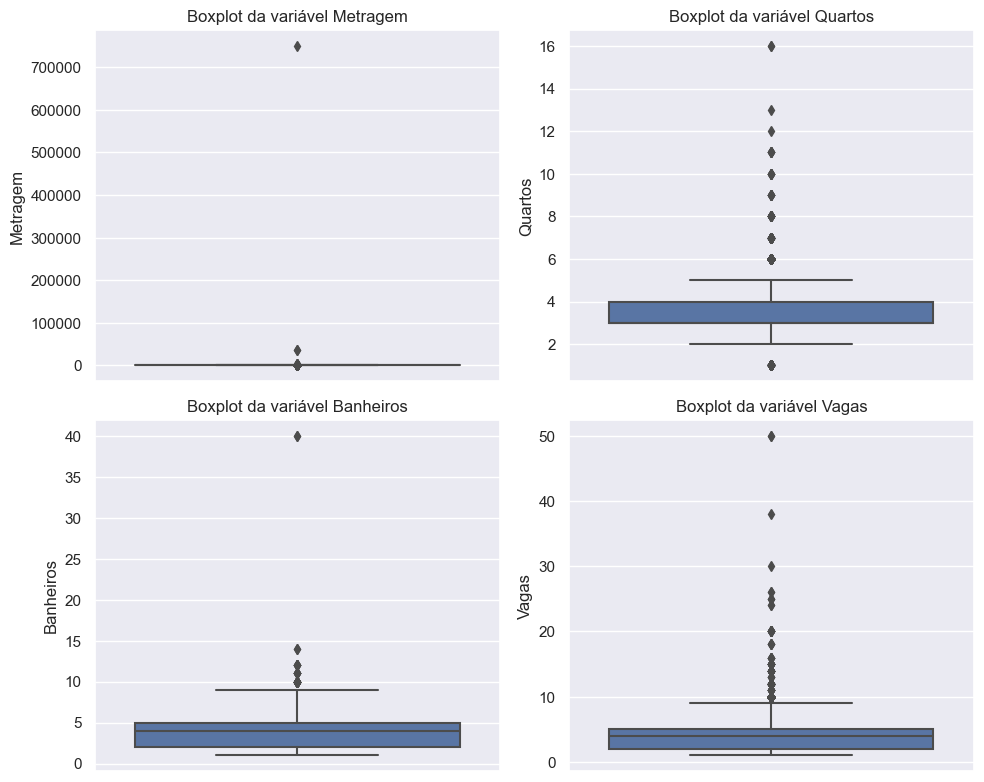

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Boxplot da variável Metragem
sns.boxplot(data=df3_imoveis, y='Metragem', ax=ax[0, 0])
ax[0, 0].set_title('Boxplot da variável Metragem')

# Boxplot da variável Quartos
sns.boxplot(data=df3_imoveis, y='Quartos', ax=ax[0, 1])
ax[0, 1].set_title('Boxplot da variável Quartos')

# Boxplot da variável Banheiros
sns.boxplot(data=df3_imoveis, y='Banheiros', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot da variável Banheiros')

# Boxplot da variável Vagas
sns.boxplot(data=df3_imoveis, y='Vagas', ax=ax[1, 1])
ax[1, 1].set_title('Boxplot da variável Vagas')

plt.tight_layout()

plt.show()

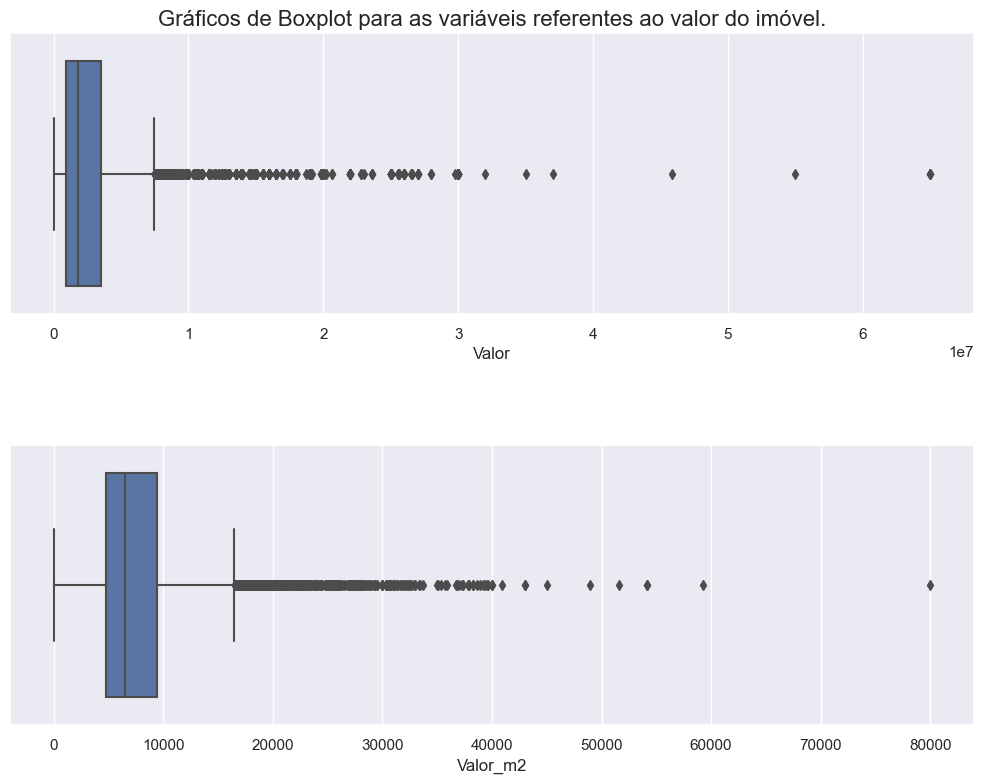

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sns.boxplot(data=df3_imoveis, x='Valor', ax=ax[0])

sns.boxplot(data=df3_imoveis, x='Valor_m2', ax=ax[1])

ax[0].set_title('Gráficos de Boxplot para as variáveis referentes ao valor do imóvel.', fontsize = 16)
plt.tight_layout(h_pad = 5)

plt.show()

**Variáveis Categóricas**

In [23]:
cat_attr.describe().rename({'count': 'Quantidade', 'unique': 'Qtd. Valores Únicos', 'top': 'Moda', 'freq': 'Freq. da Moda'}).T

,Quantidade,Qtd. Valores Únicos,Moda,Freq. da Moda
Rua,6107,3006,Rua Alberto Faria,24
Bairro,9146,697,Alto de Pinheiros,369
Cidade,9156,1,São Paulo,9156


<a id="Fase-3"></a>

# FASE 3
___

## Análise Exploratória dos Dados

In [24]:
df4_imoveis = df3_imoveis.copy()

### Análise Univariada

##### Variáveis Numéricas

##### `Metragem`

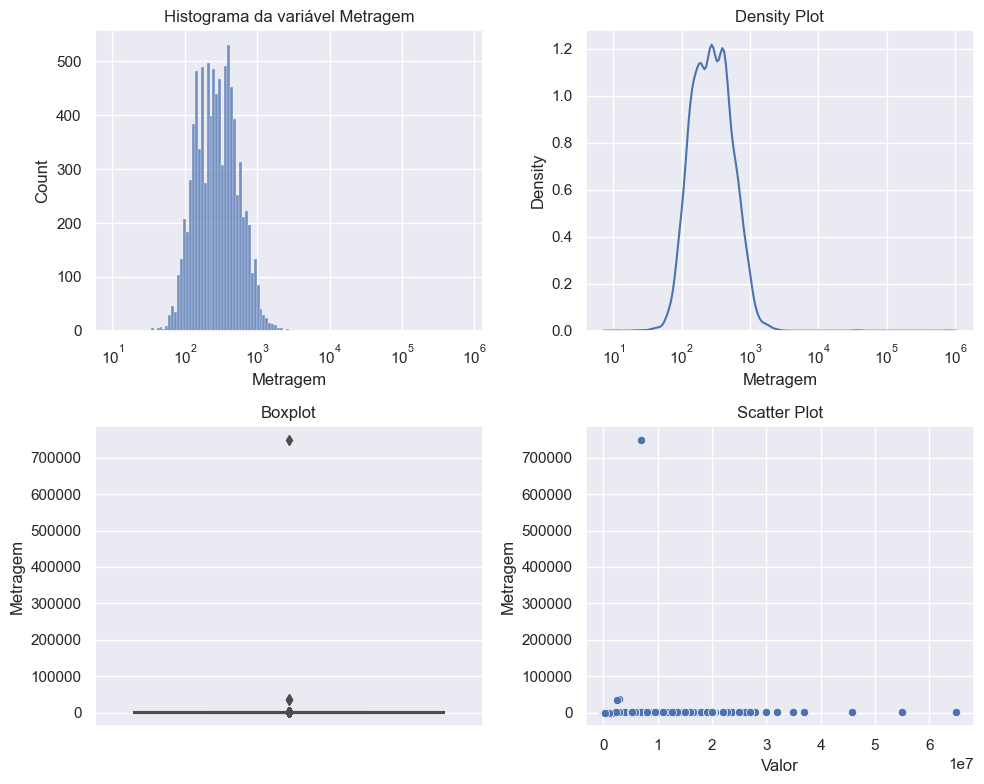

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.histplot(data=df4_imoveis, x='Metragem', ax=ax[0, 0], log_scale=True)#, kde = True, log_scale = True, bins = 25)
ax[0, 0].set_title('Histograma da variável Metragem')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis, x='Metragem', ax=ax[0, 1], log_scale=True)
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Metragem', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis, x='Valor', y='Metragem', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### `Quartos`

Imprimindo gráficos elucidativos

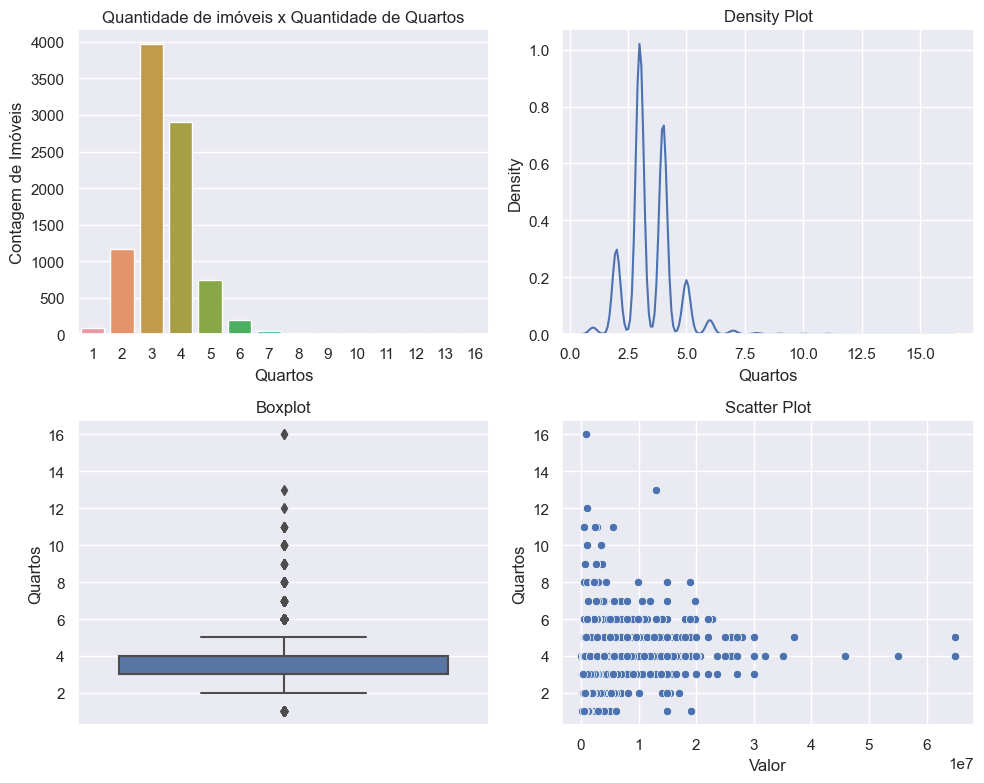

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.countplot(data=df4_imoveis, x='Quartos', ax=ax[0, 0])
ax[0, 0].set_title('Quantidade de imóveis x Quantidade de Quartos')
ax[0, 0].set_ylabel('Contagem de Imóveis')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis, x='Quartos', ax=ax[0, 1])
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Quartos', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis, x='Valor', y='Quartos', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### `Banheiros`

Imprimindo gráficos elucidativos

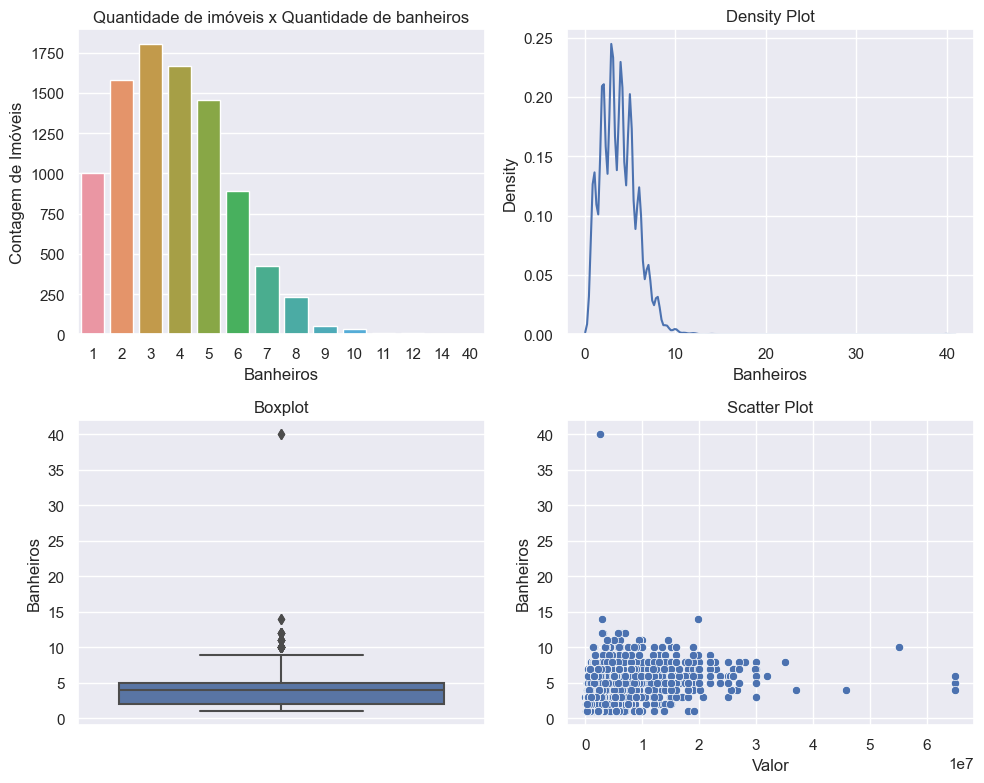

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.countplot(data=df4_imoveis, x='Banheiros', ax=ax[0, 0])
ax[0, 0].set_title('Quantidade de imóveis x Quantidade de banheiros')
ax[0,0].set_ylabel('Contagem de Imóveis')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis, x='Banheiros', ax=ax[0, 1])
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Banheiros', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis, x='Valor', y='Banheiros', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### `Vagas`

Imprimindo gráficos elucidativos

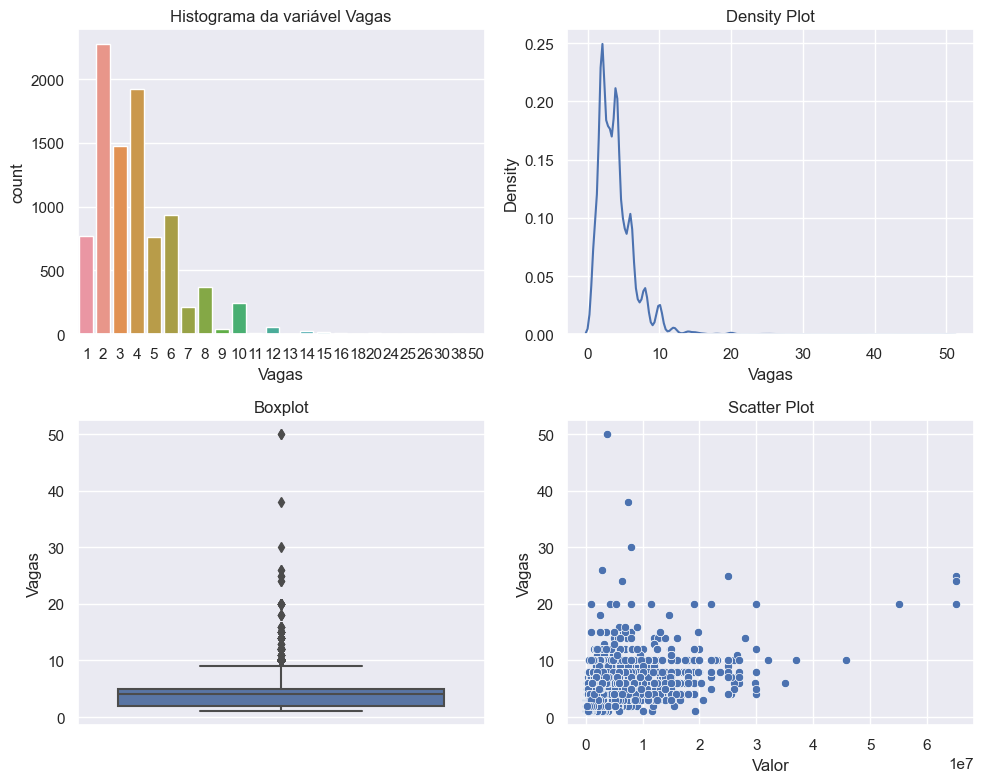

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.countplot(data=df4_imoveis, x='Vagas', ax=ax[0, 0])
ax[0, 0].set_title('Histograma da variável Vagas')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis, x='Vagas', ax=ax[0, 1])
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Vagas', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis, x='Valor', y='Vagas', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### `Valor`

Imprimindo gráficos elucidativos

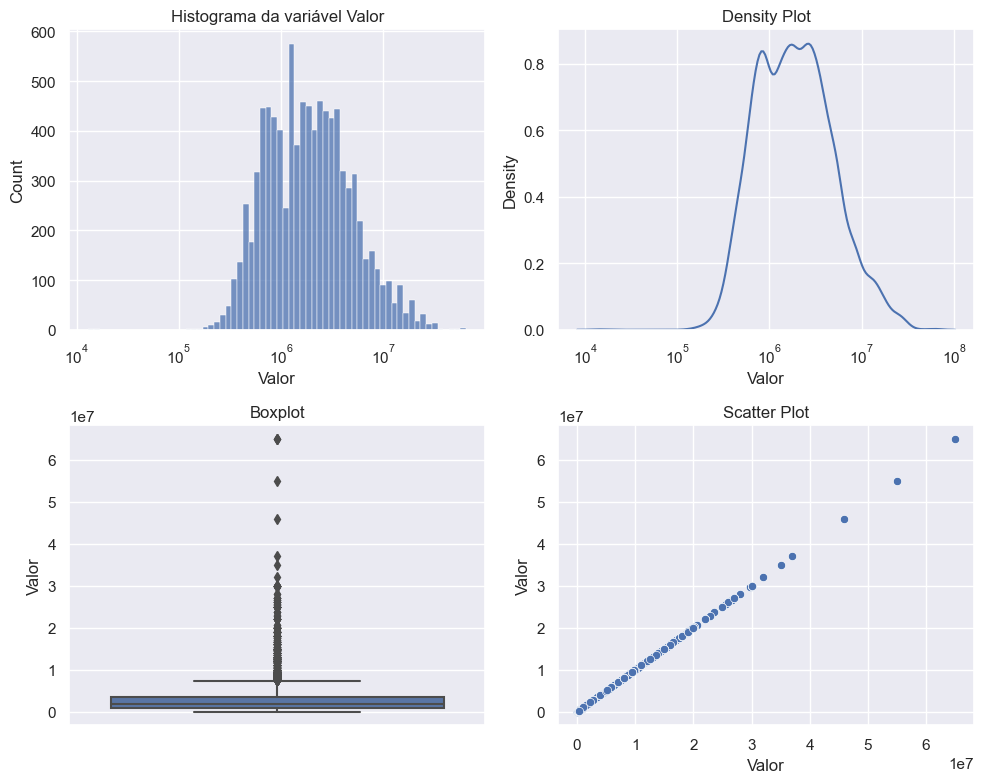

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.histplot(data=df4_imoveis, x='Valor', ax=ax[0, 0], log_scale=True)
ax[0, 0].set_title('Histograma da variável Valor')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis, x='Valor', ax=ax[0, 1], log_scale=True)
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Valor', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis, x='Valor', y='Valor', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### `Valor_m2`

Imprimindo gráficos elucidativos

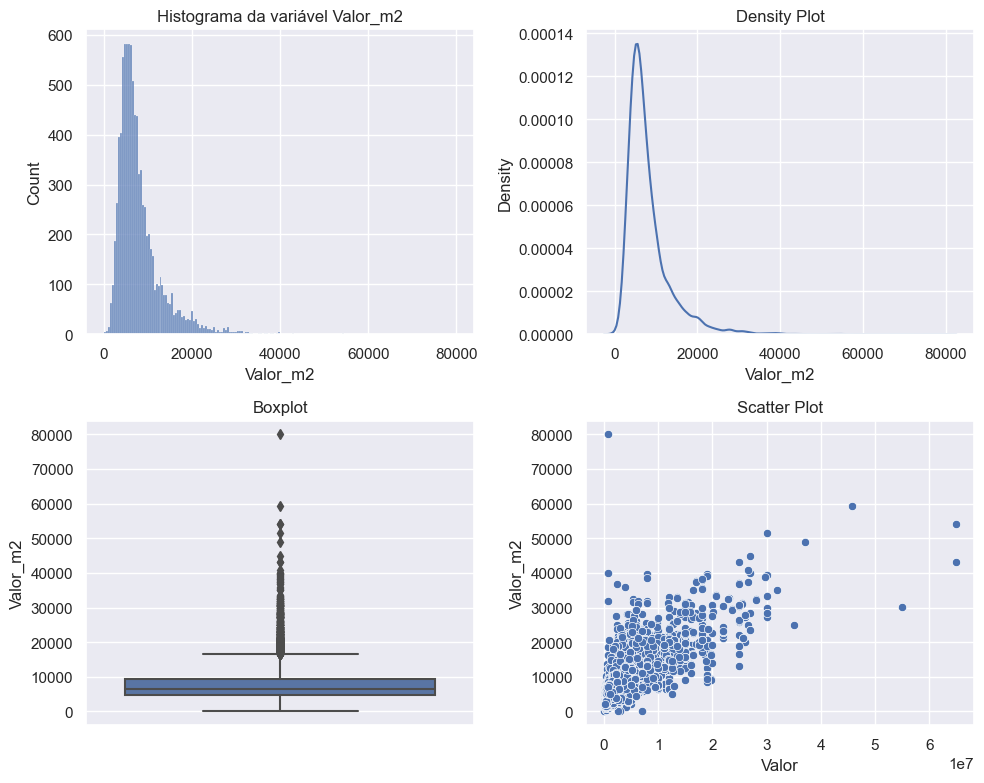

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.histplot(data=df4_imoveis, x='Valor_m2', ax=ax[0, 0])
ax[0, 0].set_title('Histograma da variável Valor_m2')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis, x='Valor_m2', ax=ax[0, 1])
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Valor_m2', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis, x='Valor', y='Valor_m2', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### Variáveis Categóricas

##### `Rua`

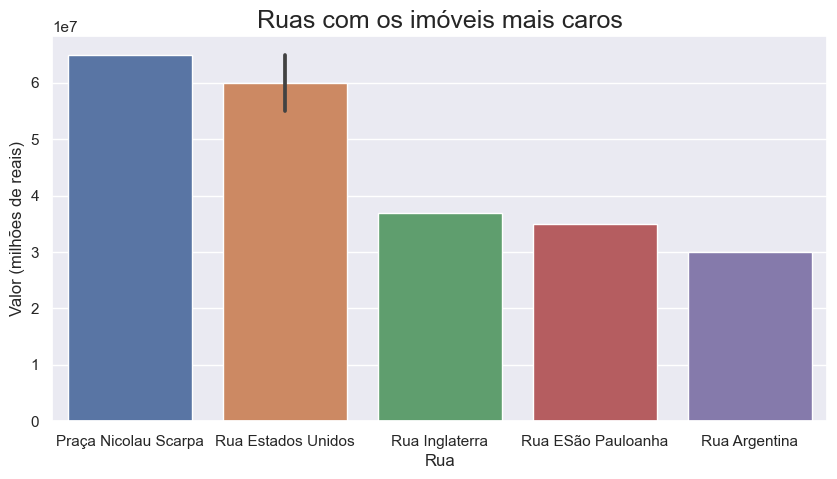

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))

df_rua = df4_imoveis.sort_values(by='Valor', ascending = False)

sns.barplot(data=df_rua[:10], y = 'Valor', x='Rua')
ax.set_title('Ruas com os imóveis mais caros', size=18)
ax.set_xlabel('Rua', size=12)
ax.set_ylabel('Valor (milhões de reais)', size=12)


plt.show()

##### `Bairro`

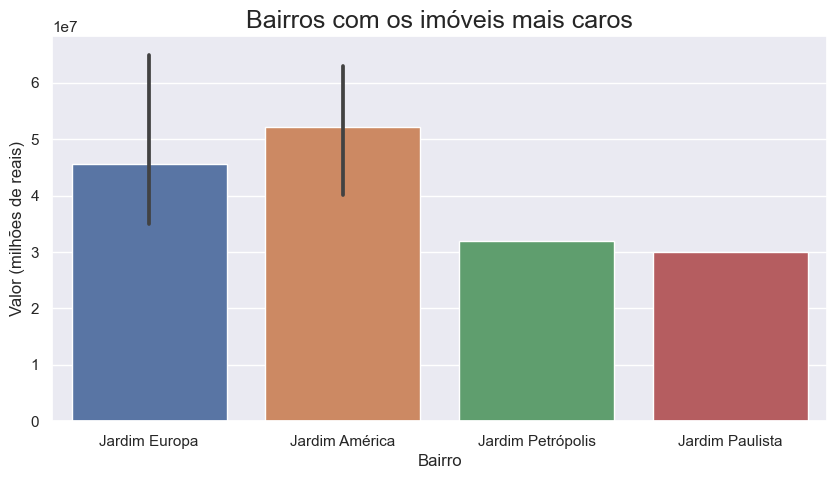

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))

df_bairros = df4_imoveis.sort_values(by='Valor', ascending = False)

sns.barplot(data=df_bairros[:10], y = 'Valor', x='Bairro')
ax.set_title('Bairros com os imóveis mais caros', size=18)
ax.set_xlabel('Bairro', size=12)
ax.set_ylabel('Valor (milhões de reais)', size=12)
plt.show()

<a id="Fase-4"></a>

# FASE 4

In [33]:
df5_imoveis = df4_imoveis.copy()
df5_imoveis

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Valor_m2
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000,7000.00
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000,7459.68
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000,3040.00
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000,2209.68
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000,5400.00
...,...,...,...,...,...,...,...,...,...
10002,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,1500000,5617.98
10003,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,665000,7000.00
10004,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,2300000,3801.65
10005,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,1050000,5121.95


In [34]:
df5_imoveis.sort_values(by='Bairro', ascending = False)

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Valor_m2
9818,NaN,Água Rasa,São Paulo,86,2,1,4,650000,7558.14
1257,Rua Capitão João Rosa da Cruz,Água Rasa,São Paulo,180,3,2,4,745000,4138.89
9853,NaN,Água Rasa,São Paulo,180,3,2,4,742000,4122.22
9089,Rua Vergel,Água Rasa,São Paulo,341,2,2,3,625000,1832.84
9145,Rua Itaqueri,Água Rasa,São Paulo,150,3,3,3,790000,5266.67
...,...,...,...,...,...,...,...,...,...
8739,"Rua Alvorada do Sul, 3773",NaN,São Paulo,683,4,8,8,6895000,10095.17
8868,"Rua Professor Eduardo Monteiro, 3773",NaN,São Paulo,555,3,5,6,4000000,7207.21
8992,"Rua Professor Eduardo Monteiro, 3773",NaN,São Paulo,555,3,5,6,4000000,7207.21
9310,"Rua Professor Lúcio Martins Rodrigues, 3773",NaN,São Paulo,358,4,6,7,1600000,4469.27


In [35]:
indexes_to_drop = find_outliers_tucker(df5_imoveis['Metragem']) 
df5_imoveis.drop(indexes_to_drop, inplace=True)

indexes_to_drop = find_outliers_tucker(df5_imoveis['Quartos']) 
df5_imoveis.drop(indexes_to_drop, inplace=True)

indexes_to_drop = find_outliers_tucker(df5_imoveis['Banheiros']) 
df5_imoveis.drop(indexes_to_drop, inplace=True)

indexes_to_drop = find_outliers_tucker(df5_imoveis['Vagas']) 
df5_imoveis.drop(indexes_to_drop, inplace=True)

indexes_to_drop = find_outliers_tucker(df5_imoveis['Valor']) 
df5_imoveis.drop(indexes_to_drop, inplace=True)

indexes_to_drop = find_outliers_tucker(df5_imoveis['Valor_m2']) 
df5_imoveis.drop(indexes_to_drop, inplace=True)

In [36]:
df5_imoveis_group = df5_imoveis[["Metragem", "Quartos", "Banheiros", "Vagas", "Valor", "Valor_m2"]]

In [37]:
kmeans = KMeans(n_clusters=5)

In [38]:
kmeans.fit(df5_imoveis_group)

KMeans(n_clusters=5)

In [39]:
kmeans.labels_

array([1, 0, 0, ..., 0, 0, 0])

<Axes: xlabel='Metragem', ylabel='Valor'>

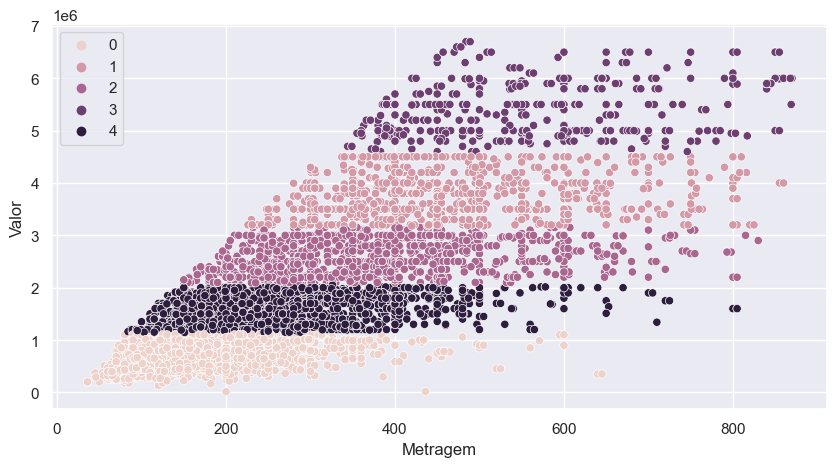

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=df5_imoveis_group, x="Metragem", y="Valor", hue=kmeans.labels_)

<Axes: xlabel='Banheiros', ylabel='Valor'>

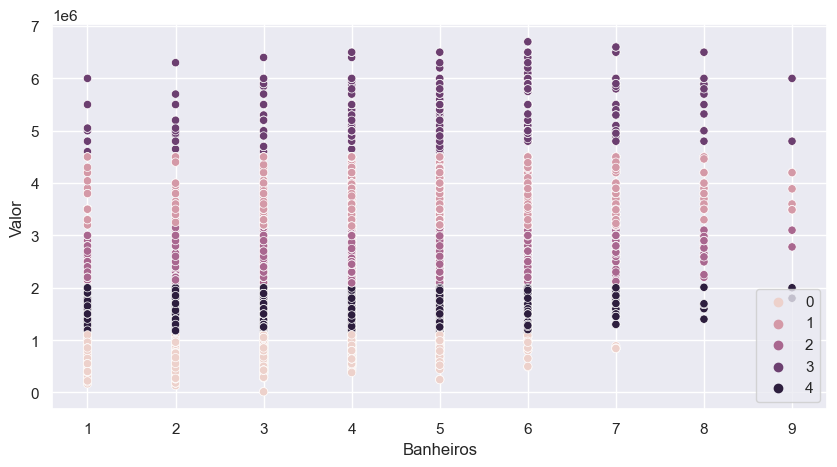

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=df5_imoveis_group, x="Banheiros", y="Valor", hue=kmeans.labels_)

<Axes: xlabel='Quartos', ylabel='Valor'>

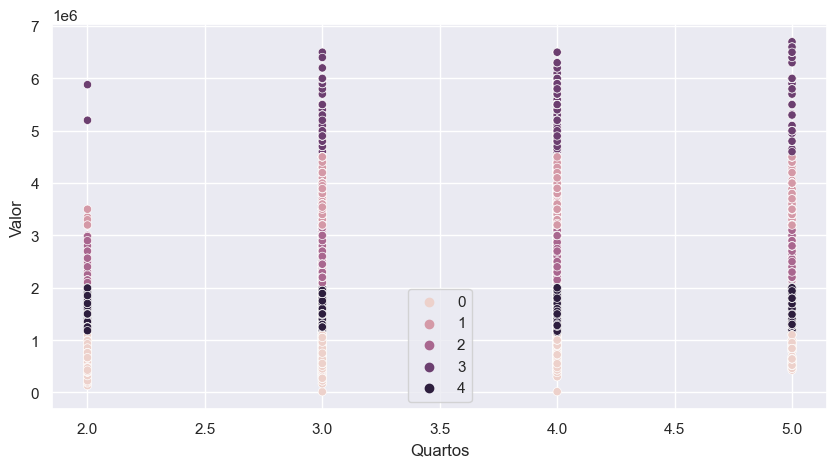

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=df5_imoveis_group, x="Quartos", y="Valor", hue=kmeans.labels_)

Após analisar as possibilidades de agrupamento usando o K-Means, iremos deixar os dados mais legíveis no relatório. Pensamos em algumas possibilidades:
- Separar os imóveis em grupos, cada grupo seria composto por um intervalo de valor por metro quadrado. Por exemplo, no grupo 1 entraria os imóveis mais caros em valor por metro quadrado, do grupo 2 ao grupo 4 entraria os imóveis com intervalos de valores à definir e no grupo 5 seriam os imóveis com o preço por metro quadrado mais barato.
- Pegar a media de valor do imóvel por bairros e agrupar os 10 mais valorizados tentando relacionar o preço e a metragem do imóvel.